Juypter notebook focusing on the investigation and use of the MS COCO dataset. This was created for CSU's CS445

The goal of this model is to recognize and select cats, dogs, cows, horses, and birds out of a photo

With that in mind we will be developing it specifically for instance segmentation

Contributers: Tucker Laurence, Yasas Wijesekara

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
import urllib
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from collections import Counter
import random

Global variables used to select conditions about the dataset


In [361]:
annotation_dir='./../annotations'
val_data_name='val2017'
train_data_name='train2017'

val_image_dir = './../datasets/val'
train_image_dir = './../datasets/train'

relevant_categories = ['cat', 'dog', 'cow', 'horse', 'bird']

This section focuses on the importing and loading of the dataset VIA pycotools.coco, which is the official access tools for MS COCO

In [363]:
class CocoSegmentationDataset(Dataset):
    def __init__(self, img_dir, annotation_directory, data_name, relevant_categories, transforms=None):
        # Initialize COCO API and get data during instantiation
        annFile = '{}/instances_{}.json'.format(annotation_directory, data_name)
        self.coco = COCO(annFile)
        
        self.img_dir = img_dir
        self.relevant_categories = relevant_categories
        
        category_ids, image_ids = self.instantiate_ids()
        
        self.image_ids = image_ids
        self.category_ids = category_ids
        self.transforms = transforms

    def instantiate_ids(self):
        category_ids = self.coco.getCatIds(catNms=self.relevant_categories)
        image_ids = []
        
        for category in category_ids:
            temp_img_ids = self.coco.getImgIds(catIds=category)
            image_ids += temp_img_ids
        
        image_ids = list(set(image_ids))
        
        print(f"Found {len(image_ids)} images for {self.relevant_categories}")
        
        return category_ids, image_ids

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, index):
        img_id = self.image_ids[index]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        image = Image.open(img_path).convert("RGB")

        ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds=self.category_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)

        masks = []
        boxes = []
        labels = []

        for ann in anns:
            mask = self.coco.annToMask(ann)
            masks.append(mask)

            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])

            labels.append(ann['category_id'])

        masks = torch.as_tensor(np.array(masks), dtype=torch.uint8)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': torch.tensor([img_id])
        }

        if self.transforms:
            image, target = self.transforms(image, target)

        return image, target
    
    def download_images(self, verbose=False):
        current_image_count = 1
        total_image_count = len(self)

        if not os.path.exists(self.img_dir):
            os.makedirs(self.img_dir)

        for img_id in self.image_ids:
            img_info = self.coco.loadImgs(img_id)[0]
            file_name = img_info['file_name']
            url = img_info.get('coco_url')

            img_count_string = f'{current_image_count}/{total_image_count}'

            if url is None:
                print(f"No URL found for image {file_name}, skipping.")
                continue

            save_path = os.path.join(self.img_dir, file_name)
            if not os.path.exists(save_path):
                try:
                    urllib.request.urlretrieve(url, save_path)
                    if verbose: print(f"{img_count_string} Downloaded {file_name}")
                except Exception as e:
                    if verbose:  print(f"{img_count_string} Failed to download {file_name}: {e}")
            else:
                if verbose: print(f"{img_count_string} Image already exists: {file_name}")

            current_image_count += 1

        print(f'Interfaced with {current_image_count-1} unique images')

    def show_image(self, index):
        image, _ = self.__getitem__(index)
        if isinstance(image, torch.Tensor):
            image = F.to_pil_image(image)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Image ID: {self.image_ids[index]}")
        plt.show()

    def show_image_with_boxes(self, index):
        image, target = self.__getitem__(index)

        # Convert only if needed
        if isinstance(image, torch.Tensor):
            image = F.to_pil_image(image)

        fig, ax = plt.subplots(1)
        ax.imshow(image)

        boxes = target['boxes']
        labels = target['labels']

        # Map category IDs to category names
        category_names = [self.coco.loadCats([label.item()])[0]['name'] for label in labels]

        for box, label, category_name in zip(boxes, labels, category_names):
            x1, y1, x2, y2 = box
            rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)
            ax.text(x1, y1, category_name, color='white', fontsize=8, bbox=dict(facecolor='red', edgecolor='none', pad=1))

        plt.axis('off')
        plt.title(f"Image ID: {self.image_ids[index]}")
        plt.show()

    def show_image_with_masks(self, index):
        image, target = self.__getitem__(index)
        masks = target['masks'].numpy()

        fig, ax = plt.subplots()
        ax.imshow(image)

        for i, mask in enumerate(masks):
            ax.imshow(mask, alpha=0.4)

        plt.axis('off')
        plt.title(f"Image with Masks - ID: {self.image_ids[index]}")
        plt.show()

    def show_data_distribution(self):
        all_labels = []
        for index in range(len(self)):
            _, target = self.__getitem__(index)
            all_labels.extend(target['labels'].tolist())

        label_counts = Counter(all_labels)
        category_names = [self.coco.loadCats([cat_id])[0]['name'] for cat_id in label_counts.keys()]
        counts = list(label_counts.values())

        plt.figure(figsize=(10, 5))
        plt.bar(category_names, counts, color='skyblue')
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Number of Instances')
        plt.title('Category Distribution in Dataset')
        plt.tight_layout()
        plt.show()


In [364]:
val_dataset = CocoSegmentationDataset(val_image_dir, annotation_dir, val_data_name, relevant_categories)

loading annotations into memory...
Done (t=0.40s)
creating index...
index created!
Found 666 images for ['cat', 'dog', 'cow', 'horse', 'bird']


In [365]:
val_dataset.download_images()

Interfaced with 666 unique images


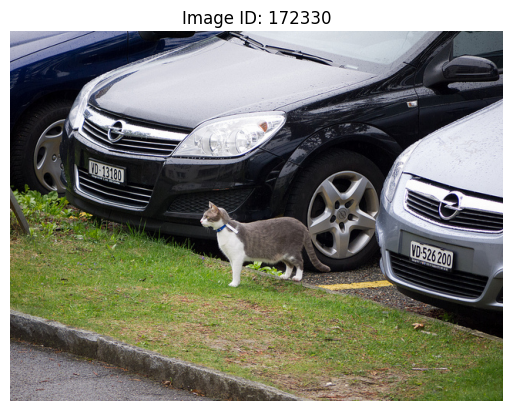

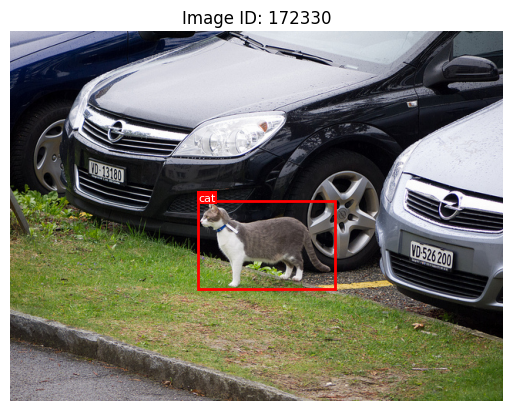

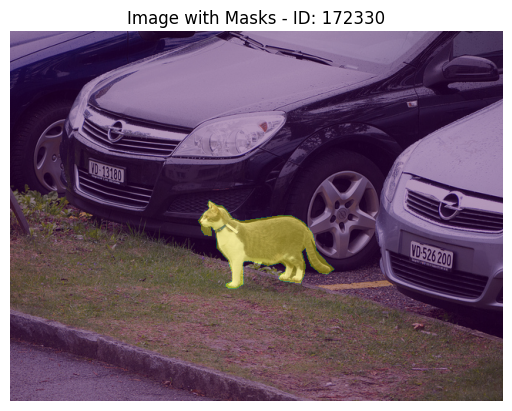

In [366]:
r_idx = random.randrange(len(val_dataset) - 1)
val_dataset.show_image(r_idx)
val_dataset.show_image_with_boxes(r_idx)
val_dataset.show_image_with_masks(r_idx)

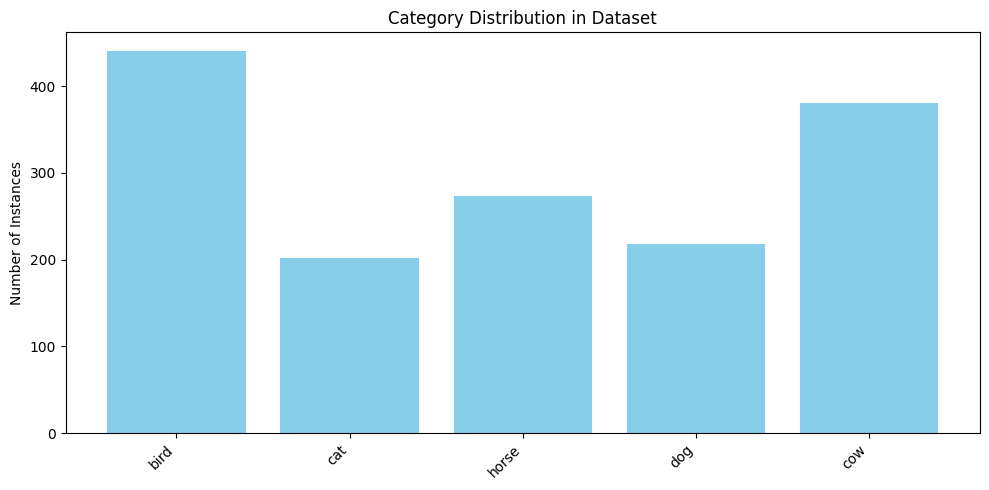

In [367]:
val_dataset.show_data_distribution()

This section focuses on the data preprocessing:

Includes Normalization of pixel values

Standardization of picture size

scaling of bounding box dimensions based on picture standardization

MODEL 1 Custom Preprocessing and training/test/val

MODEL 2 Custom Preprocessing and training/test/val

Graphical displays and performance investigation